In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
print("Device Name:", torch.cuda.get_device_name(0))
print("Current Device:", torch.cuda.current_device())

Device Name: NVIDIA GeForce RTX 2050
Current Device: 0


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
df = pd.read_csv("fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

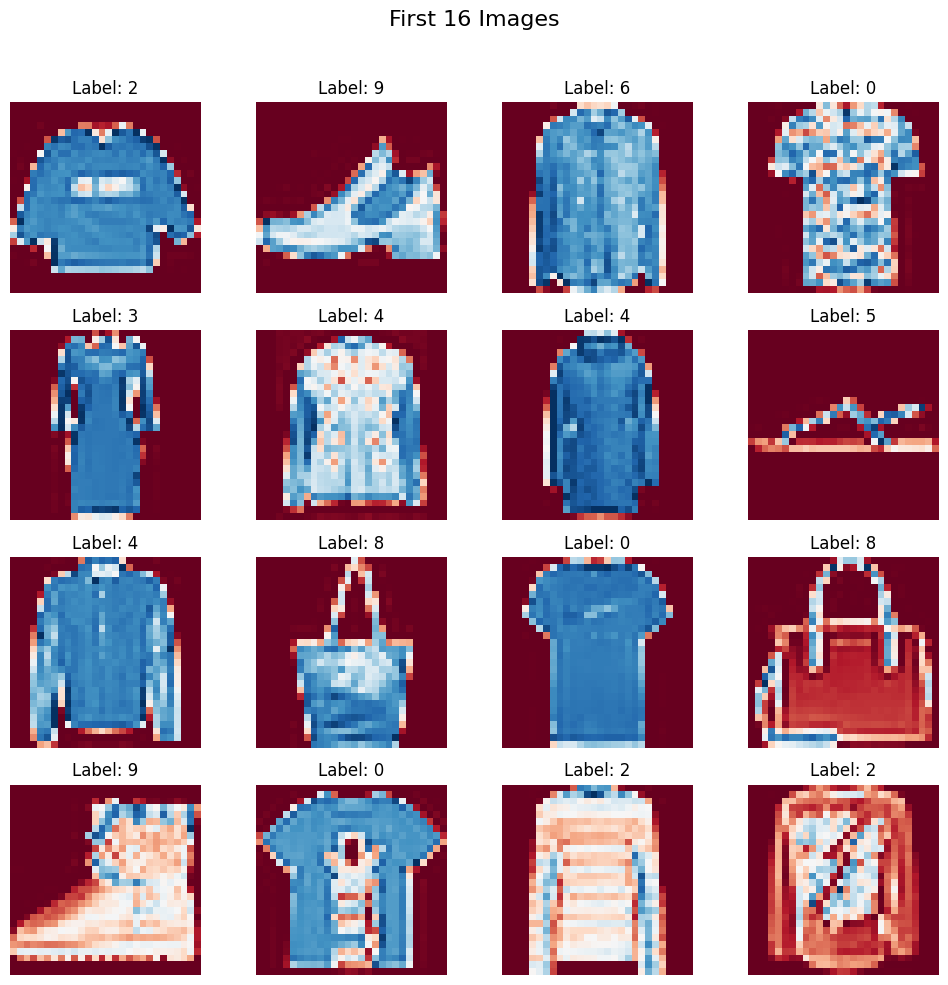

In [7]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img, cmap="RdBu")  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [8]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = X_train/255.0
X_test = X_test/255.0

In [11]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [12]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [14]:
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [17]:
train_dataset.features.shape

torch.Size([48000, 1, 28, 28])

In [18]:
model = MyNN(train_dataset.features.shape[1]).to(device)

In [19]:
model

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [20]:
loss_fc = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [21]:
# training loop
import time
start_time = time.time()

epochs = 100

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = loss_fc(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

end_time = time.time()
print(f"Total time of training is {(end_time - start_time)/60} Minutes!")

Epoch: 1 , Loss: 0.6449234943389892
Epoch: 2 , Loss: 0.3858393851369619
Epoch: 3 , Loss: 0.32699158694346747
Epoch: 4 , Loss: 0.29107362251480423
Epoch: 5 , Loss: 0.26431918622056644
Epoch: 6 , Loss: 0.24439699640373388
Epoch: 7 , Loss: 0.23032772045830885
Epoch: 8 , Loss: 0.213271941733857
Epoch: 9 , Loss: 0.19921846278756858
Epoch: 10 , Loss: 0.18903825015171122
Epoch: 11 , Loss: 0.17527996308232346
Epoch: 12 , Loss: 0.16642838805758706
Epoch: 13 , Loss: 0.1572029812807838
Epoch: 14 , Loss: 0.14812519571495553
Epoch: 15 , Loss: 0.14280726297882695
Epoch: 16 , Loss: 0.13163248528648788
Epoch: 17 , Loss: 0.12679716644529254
Epoch: 18 , Loss: 0.12260323818555723
Epoch: 19 , Loss: 0.11188850237273922
Epoch: 20 , Loss: 0.10962608162996669
Epoch: 21 , Loss: 0.10346889894300451
Epoch: 22 , Loss: 0.0978231205342648
Epoch: 23 , Loss: 0.0921728694702809
Epoch: 24 , Loss: 0.08608442765544169
Epoch: 25 , Loss: 0.08441020527311291
Epoch: 26 , Loss: 0.08183575232497727
Epoch: 27 , Loss: 0.08189866

In [22]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [23]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9234166666666667


In [24]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9997916666666666


In [25]:
# yes there is little bit overfitting